In [106]:
%matplotlib inline

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse as sparse

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from nltk.corpus import stopwords
from sklearn.cross_validation import StratifiedKFold
from sklearn.naive_bayes import BernoulliNB
from sklearn import linear_model
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import recall_score

In [107]:
sqlobject = sqlite3.connect('./database.sqlite')
reviews = pd.read_sql_query("""SELECT Score, Summary FROM Reviews""", sqlobject)
original = reviews.copy()
reviews = original.copy()
print(reviews.shape)


(568454, 2)


In [108]:
reviews = reviews.dropna()
print (reviews.shape)
print (reviews.head(25))

(568454, 2)
    Score                                            Summary
0       5                              Good Quality Dog Food
1       1                                  Not as Advertised
2       4                              "Delight" says it all
3       2                                     Cough Medicine
4       5                                        Great taffy
5       4                                         Nice Taffy
6       5      Great!  Just as good as the expensive brands!
7       5                             Wonderful, tasty taffy
8       5                                         Yay Barley
9       5                                   Healthy Dog Food
10      5                    The Best Hot Sauce in the World
11      5  My cats LOVE this "diet" food better than thei...
12      1               My Cats Are Not Fans of the New Food
13      4                                  fresh and greasy!
14      5                       Strawberry Twizzlers - Yummy
15      5   

In [109]:
scores = reviews['Score']
reviews['Score'] = reviews['Score'].apply(lambda x : 'pos' if x > 3 else 'neg')

In [110]:
scores.mean()

4.1831986405232433

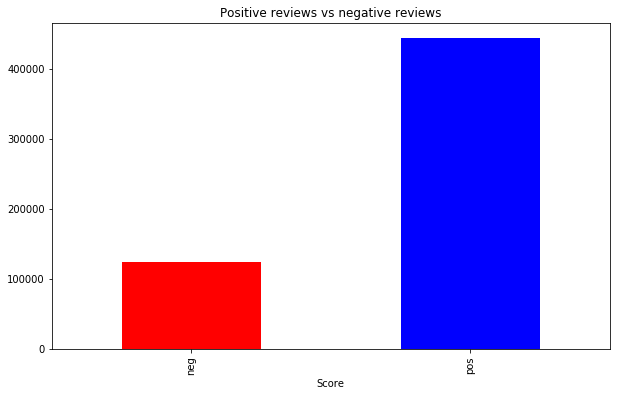

In [111]:
reviews.groupby('Score')['Summary'].count()
reviews.groupby('Score')['Summary'].count().plot(kind='bar',color=['r','b'],title='Positive reviews vs negative reviews',figsize=(10,6))

In [112]:

print ('Percentage of negative reviews %.2f %%' % ((reviews.groupby('Score')['Summary'].count()['neg'])*100.0/len(reviews)))
print ('Percentage of positive reviews %.2f %%' % ((reviews.groupby('Score')['Summary'].count()['pos'])*100.0/len(reviews)))

Percentage of negative reviews 21.93 %
Percentage of positive reviews 78.07 %


In [113]:

def splitPosNeg(Summaries):
    neg = reviews.loc[Summaries['Score']=='neg']
    pos = reviews.loc[Summaries['Score']=='pos']
    return [pos,neg]

In [114]:
[pos,neg] = splitPosNeg(reviews)


In [115]:
#preprocessing steps

#stemmer = PorterStemmer()
lemmatizer = nltk.WordNetLemmatizer()
stop = stopwords.words('english')
translation = str.maketrans(string.punctuation,' '*len(string.punctuation))

def preprocessing(line):
    tokens=[]
    line = line.translate(translation)
    line = nltk.word_tokenize(line.lower())
    for t in line:
        #if(t not in stop):
            #stemmed = stemmer.stem(t)
        stemmed = lemmatizer.lemmatize(t)
        tokens.append(stemmed)
    return ' '.join(tokens)

In [116]:
pos_data = []
neg_data = []
nltk.download('punkt')
nltk.download('wordnet')
for p in pos['Summary']:
    pos_data.append(preprocessing(p))

for n in neg['Summary']:
    neg_data.append(preprocessing(n))  

[nltk_data] Downloading package punkt to /home/sonali/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/sonali/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [117]:
data = pos_data + neg_data
labels = np.concatenate((pos['Score'].values,neg['Score'].values))

In [118]:
[Data_train,Data_test,Train_labels,Test_labels] = train_test_split(data,labels , test_size=0.25, random_state=20160121,stratify=labels)

In [119]:
t = []
for line in Data_train:
    l = nltk.word_tokenize(line)
    for w in l:
        t.append(w)

In [120]:
word_features = nltk.FreqDist(t)
print (len(word_features))

27048


In [121]:
vec_all = CountVectorizer()
ctr_features_all = vec_all.fit_transform(Data_train)

In [122]:
tf_vec_all = TfidfTransformer()
tr_features_all = tf_vec_all.fit_transform(ctr_features_all)

In [123]:
cte_features_all = vec_all.transform(Data_test)
te_features_all = tf_vec_all.transform(cte_features_all)

In [124]:
svd = TruncatedSVD(n_components=200)
tr_features_truncated = svd.fit_transform(tr_features_all)

In [125]:
te_features_truncated = svd.transform(te_features_all)

In [126]:
svd = TruncatedSVD(n_components=200)
ctr_features_truncated = svd.fit_transform(ctr_features_all)
cte_features_truncated = svd.transform(cte_features_all)

In [127]:
models = {'BernoulliNB':BernoulliNB(binarize=0.5)
          ,'Logistic' : linear_model.LogisticRegression(C=1e5),'Decision Tree' : DecisionTreeClassifier(random_state=20160121, criterion='entropy')}

In [128]:
results_svd = pd.DataFrame()

foldnum = 0
tfprediction = {}
cprediction = {}
for name,model in models.items():
        model.fit(tr_features_truncated, Train_labels)
        tfprediction[name] = model.predict(te_features_truncated)
        tfaccuracy = metrics.accuracy_score(tfprediction[name],Test_labels)
        
        #model.fit(ctr_features_truncated,Train_labels)
        #cprediction[name] = model.predict(cte_features_truncated)
        #caccuracy = metrics.accuracy_score(cprediction[name],Test_labels)

        results_svd.loc[foldnum,'Model']=name
        results_svd.loc[foldnum,'TF-IDF Accuracy']=tfaccuracy
        #results_svd.loc[foldnum,'Count Accuracy']=caccuracy
        foldnum = foldnum+1
print (results_svd)


           Model  TF-IDF Accuracy
0       Logistic         0.846215
1  Decision Tree         0.862420
2    BernoulliNB         0.792561


In [129]:
for name,model in models.items():
    print ("Classification report for ",name)
    print(metrics.classification_report(Test_labels, tfprediction[name]))
    print("\n")

Classification report for  Logistic
             precision    recall  f1-score   support

        neg       0.77      0.43      0.55     31169
        pos       0.86      0.96      0.91    110945

avg / total       0.84      0.85      0.83    142114



Classification report for  Decision Tree
             precision    recall  f1-score   support

        neg       0.68      0.69      0.69     31169
        pos       0.91      0.91      0.91    110945

avg / total       0.86      0.86      0.86    142114



Classification report for  BernoulliNB
             precision    recall  f1-score   support

        neg       0.89      0.06      0.12     31169
        pos       0.79      1.00      0.88    110945

avg / total       0.81      0.79      0.71    142114





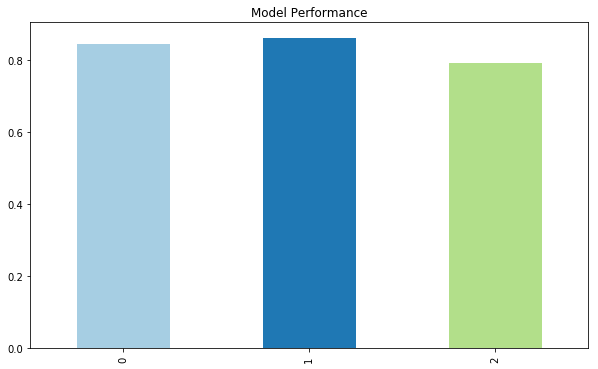

In [135]:
results_svd.plot(kind='bar',color=[plt.cm.Paired(np.arange(len(results_svd)))],title='Model Performance',figsize=(10,6),legend=False)

In [53]:
## comparing negative samples accuracies
negcom = pd.DataFrame()
for name,model in models.items():
    p= recall_score(Test_labels,tfprediction[name],pos_label='neg')
    negcom.loc[name,'recall'] = p

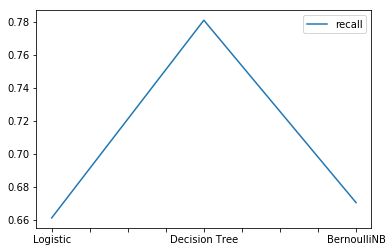

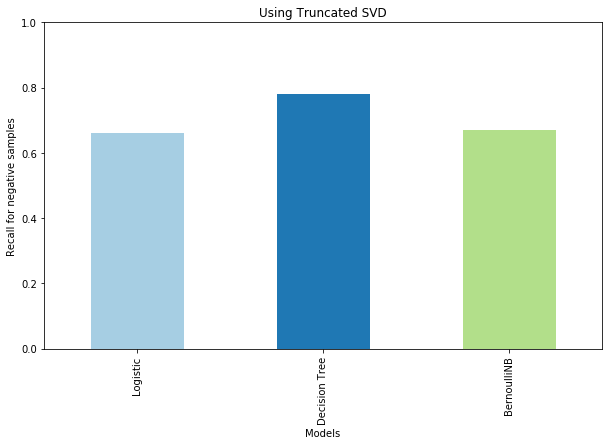

In [139]:
negcom.plot()
pl = negcom.plot(kind='bar',color=[plt.cm.Paired(np.arange(len(negcom)))],title='Using Truncated SVD',figsize=(10,6),legend=False)
pl.set(xlabel='Models',ylabel='Recall for negative samples')
lim = plt.ylim([0,1])

In [56]:
topwords = [fpair[0] for fpair in list(word_features.most_common(5000))]

In [58]:
print (word_features.most_common(20))

[('great', 65954), ('the', 49830), ('good', 46763), ('a', 45688), ('for', 36489), ('love', 32342), ('and', 31778), ('not', 30347), ('it', 30267), ('best', 30084), ('my', 26312), ('coffee', 22972), ('i', 22804), ('but', 22720), ('this', 22080), ('taste', 21830), ('tea', 20503), ('to', 19134), ('dog', 18996), ('product', 18697)]


In [61]:
word_his = pd.DataFrame(word_features.most_common(20),columns=['words','count'])

In [62]:
print (word_his)

      words  count
0     great  65954
1       the  49830
2      good  46763
3         a  45688
4       for  36489
5      love  32342
6       and  31778
7       not  30347
8        it  30267
9      best  30084
10       my  26312
11   coffee  22972
12        i  22804
13      but  22720
14     this  22080
15    taste  21830
16      tea  20503
17       to  19134
18      dog  18996
19  product  18697


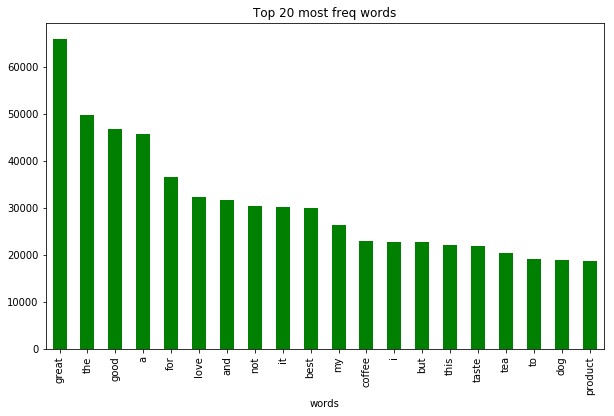

In [65]:
word_his.plot(kind='bar',x=word_his['words'],color = ('g'),legend=False,title='Top 20 most freq words',figsize=(10,6))

In [66]:
vec = CountVectorizer()
c_fit = vec.fit_transform([' '.join(topwords)])

In [67]:
tf_vec = TfidfTransformer()
tf_fit = tf_vec.fit_transform(c_fit)

In [68]:
ctr_features = vec.transform(Data_train)
tr_features = tf_vec.transform(ctr_features)

In [69]:
cte_features = vec.transform(Data_test)
te_features = tf_vec.transform(cte_features)

In [70]:
models = {'BernoulliNB':BernoulliNB()
          ,'Logistic' : linear_model.LogisticRegression(C=1e5),'Decision Tree' : DecisionTreeClassifier(random_state=20160121, criterion='entropy')}

In [71]:
results = pd.DataFrame()

foldnum = 0
tfprediction = {}
cprediction = {}
for name,model in models.items():
        
        model.fit(tr_features, Train_labels)
        tfprediction[name] = model.predict(te_features)
        tfaccuracy = metrics.accuracy_score(tfprediction[name],Test_labels)
        
        #model.fit(ctr_features,Train_labels)
        #cprediction[name] = model.predict(cte_features)
        #caccuracy = metrics.accuracy_score(cprediction[name],Test_labels)
        
        results.loc[foldnum,'TF-IDF Accuracy']=tfaccuracy
        #results.loc[foldnum,'Count Accuracy']=caccuracy
        results.loc[foldnum,'Model']=name
        foldnum = foldnum+1
print (results)


   TF-IDF Accuracy          Model
0         0.889427       Logistic
1         0.915026  Decision Tree
2         0.869330    BernoulliNB


In [72]:
for name,model in models.items():
    print ("Classification report for ",name)
    print(metrics.classification_report(Test_labels, tfprediction[name]))
    print("\n")

Classification report for  Logistic
             precision    recall  f1-score   support

        neg       0.80      0.66      0.72     31169
        pos       0.91      0.95      0.93    110945

avg / total       0.89      0.89      0.89    142114



Classification report for  Decision Tree
             precision    recall  f1-score   support

        neg       0.82      0.78      0.80     31169
        pos       0.94      0.95      0.95    110945

avg / total       0.91      0.92      0.91    142114



Classification report for  BernoulliNB
             precision    recall  f1-score   support

        neg       0.72      0.67      0.69     31169
        pos       0.91      0.93      0.92    110945

avg / total       0.87      0.87      0.87    142114





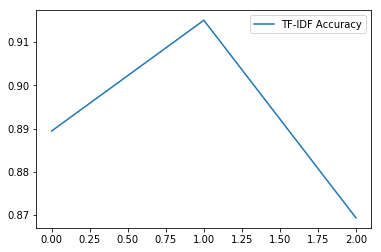

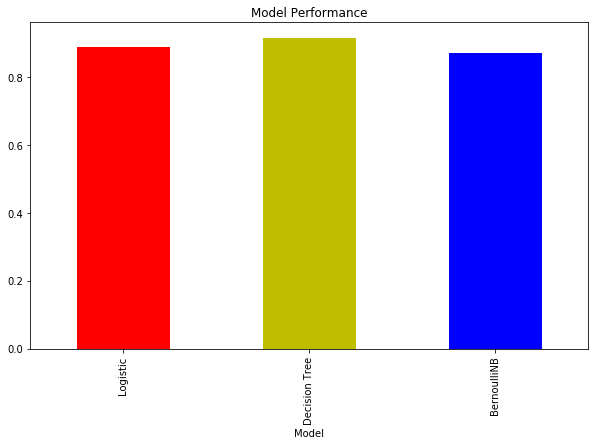

In [95]:
results.plot()
results.plot(kind='bar',color=('r','y','b'),title='Model Performance',figsize=(10,6),x='Model',legend=False)

In [83]:
## comparing negative samples accuracies
negcom = pd.DataFrame()
for name,model in models.items():
    p= recall_score(Test_labels,tfprediction[name],pos_label='neg')
    negcom.loc[name,'recall'] = p


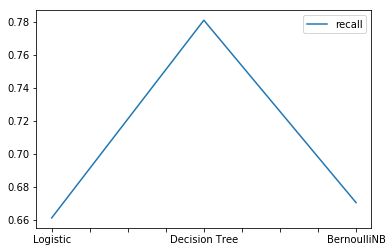

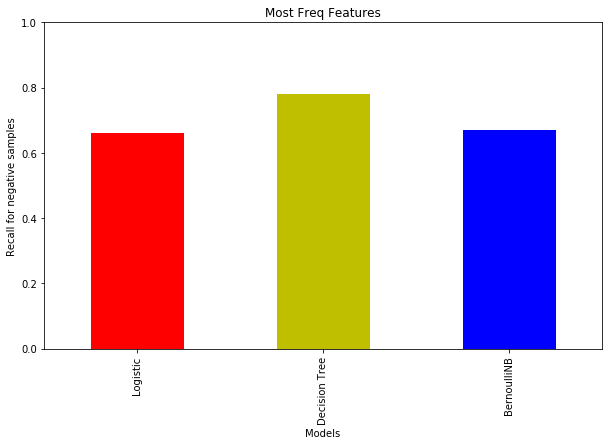

In [98]:
negcom.plot()
pl = negcom.plot(kind='bar',color=('r','y','b'),title='Most Freq Features',figsize=(10,6),legend=False)
pl.set(xlabel='Models',ylabel='Recall for negative samples')
lim = plt.ylim([0,1])